Generating Figure 1: PAM Accessibility...


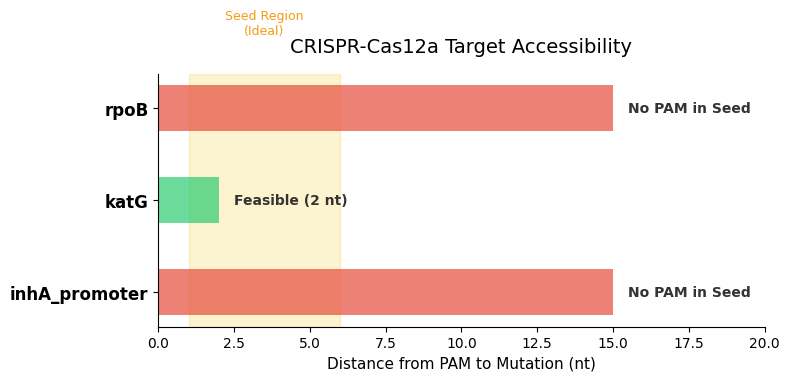

Generating Figure 2: Tracks for each gene...


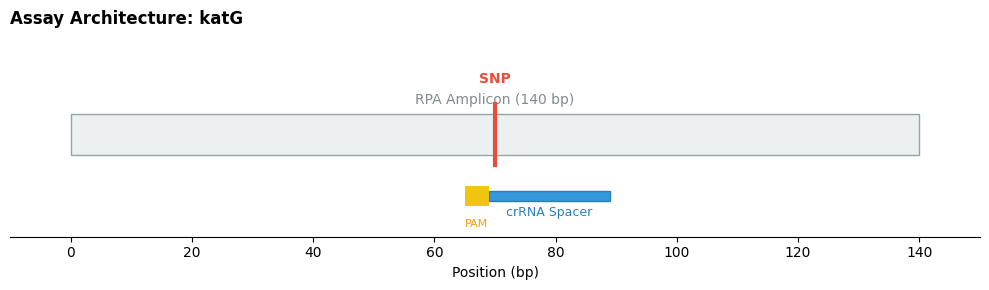

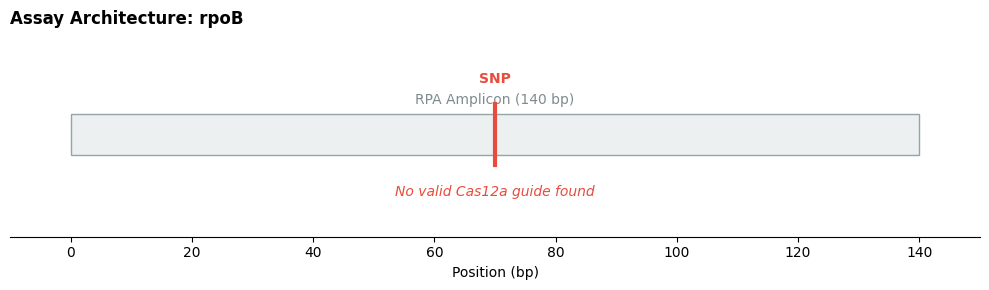

In [1]:
"""
================================================================================
NOTEBOOK 04: Visualisation of CRISPR-RPA Assay Designs
================================================================================

Objective: 
    Generate publication-quality figures illustrating the designed assays.
    1. PAM-SNP Distance Plot: Explains guide feasibility (Why katG works vs rpoB).
    2. Assay Architecture Plot: Visual map of Amplicon + Guide + Mutation.

Libraries: Matplotlib, Pandas
"""

import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np

# Setup
os.chdir(r"E:\RPA–CRISPR-model")
plt.style.use('default') # Clean style for biology plots

# Load Data
amplicons_df = pd.read_csv("data/simulated/rpa_amplicons_designed.csv")
guides_df = pd.read_csv("data/simulated/crispr_guides_designed.csv")

def plot_pam_accessibility(amplicons, guides):
    genes = amplicons["gene"].unique()
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Y-positions
    y_pos = np.arange(len(genes))
    
    # Store min distance found for each gene
    min_distances = {}
    
    for i, gene in enumerate(genes):
        # Check if we found a guide
        gene_guides = guides[guides["gene"] == gene]
        
        if not gene_guides.empty:
            # Best guide distance
            best_dist = gene_guides["snp_position_in_spacer"].min()
            color = "#2ecc71" # Green
            label = f"Feasible ({best_dist} nt)"
        else:
            # No guide found -> Distance is effectively > 10nt (Constraint)
            # We visualize this as a "gap"
            best_dist = 15 # Fake value for visualization (beyond seed)
            color = "#e74c3c" # Red
            label = "No PAM in Seed"
        
        min_distances[gene] = best_dist
        
        # Plot Bar
        ax.barh(i, best_dist, color=color, alpha=0.7, height=0.5)
        ax.text(best_dist + 0.5, i, label, va='center', fontweight='bold', color='#333333')

    # Formatting SOTA style
    ax.set_yticks(y_pos)
    ax.set_yticklabels(genes, fontsize=12, fontweight='bold')
    ax.set_xlabel("Distance from PAM to Mutation (nt)", fontsize=11)
    ax.set_title("CRISPR-Cas12a Target Accessibility", fontsize=14, pad=15)
    
    # Add Seed Region Zone (1-6 nt)
    ax.axvspan(1, 6, color='#f1c40f', alpha=0.2, zorder=0)
    ax.text(3.5, -0.8, "Seed Region\n(Ideal)", ha='center', fontsize=9, color='#f39c12')
    
    # Limits
    ax.set_xlim(0, 20)
    ax.invert_yaxis() # Top to bottom
    
    # Clean spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig("data/simulated/Fig1_PAM_Accessibility.png", dpi=300)
    plt.show()

# ============================================================================
# FIGURE 2: ASSAY ARCHITECTURE TRACKS (Genome Browser Style)
# ============================================================================

def plot_assay_tracks(gene_name, amplicon_row, guide_row=None):
    fig, ax = plt.subplots(figsize=(10, 3))
    
    # Coordinates
    amp_len = amplicon_row["amplicon_length_bp"]
    snp_pos = amplicon_row["snp_offset_in_amplicon_bp"]
    
    # 1. Draw Amplicon (Grey Bar)
    rect_amp = patches.Rectangle((0, 0.4), amp_len, 0.2, linewidth=1, edgecolor='#95a5a6', facecolor='#ecf0f1')
    ax.add_patch(rect_amp)
    ax.text(amp_len/2, 0.65, f"RPA Amplicon ({amp_len} bp)", ha='center', fontsize=10, color='#7f8c8d')
    
    # 2. Draw Mutation (Red Line)
    ax.plot([snp_pos, snp_pos], [0.35, 0.65], color='#e74c3c', linewidth=3, zorder=10)
    ax.text(snp_pos, 0.75, "SNP", ha='center', color='#e74c3c', fontweight='bold')
    
    # 3. Draw Guide (if exists)
    if guide_row is not None:
        # Guide is 20nt spacer. 
        # We need to back-calculate start from SNP position in spacer
        # guide_start + snp_pos_in_spacer - 1 = snp_pos
        guide_start = snp_pos - (guide_row["snp_position_in_spacer"] - 1)
        
        # Draw Spacer (Blue Arrow)
        # Using FancyArrow for SOTA look
        ax.arrow(guide_start, 0.2, 20, 0, width=0.05, head_width=0, head_length=0, fc='#3498db', ec='#2980b9')
        ax.text(guide_start + 10, 0.1, "crRNA Spacer", ha='center', color='#2980b9', fontsize=9)
        
        # Draw PAM (Yellow Box)
        # PAM is 5' of spacer (left side)
        pam_start = guide_start - 4
        rect_pam = patches.Rectangle((pam_start, 0.15), 4, 0.1, fc='#f1c40f', ec='none')
        ax.add_patch(rect_pam)
        ax.text(pam_start + 2, 0.05, "PAM", ha='center', fontsize=8, color='#f39c12')
        
        # Connect PAM to Spacer
        ax.plot([pam_start+4, guide_start], [0.2, 0.2], color='#2980b9', linewidth=1)

    else:
        ax.text(amp_len/2, 0.2, "No valid Cas12a guide found", ha='center', color='#e74c3c', style='italic')

    # Formatting
    ax.set_xlim(-10, amp_len + 10)
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    ax.set_xlabel("Position (bp)", fontsize=10)
    ax.set_title(f"Assay Architecture: {gene_name}", loc='left', fontsize=12, fontweight='bold')
    
    # Remove all spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.spines['bottom'].set_visible(True)
    
    plt.tight_layout()
    plt.savefig(f"data/simulated/Fig2_Assay_{gene_name}.png", dpi=300)
    plt.show()

# ============================================================================
# EXECUTE PLOTTING
# ============================================================================

print("Generating Figure 1: PAM Accessibility...")
plot_pam_accessibility(amplicons_df, guides_df)

print("Generating Figure 2: Tracks for each gene...")
# katG (Success Case)
katg_amp = amplicons_df[amplicons_df["gene"] == "katG"].iloc[0]
katg_guide = guides_df[guides_df["gene"] == "katG"].iloc[0] if not guides_df[guides_df["gene"] == "katG"].empty else None
plot_assay_tracks("katG", katg_amp, katg_guide)

# rpoB (Failure Case)
rpob_amp = amplicons_df[amplicons_df["gene"] == "rpoB"].iloc[0]
plot_assay_tracks("rpoB", rpob_amp, None)
